# Using Snowflake Database and Python to perform Analysis on the NOAA Dataset #
Working with data from the NOAA Storm Database (U.S. National Oceanic and Atmospheric Administration’s storm datbase)  loaded into a Snowflake database.

See https://docs.snowflake.com/en/user-guide/python-connector-example.html for documentation on how to use the Snowflake Python connector.
  
Details of the data-set are provided here: https://www.nws.noaa.gov/directives/sym/pd01016005curr.pdf and the original raw data-source is here: https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/ 

An overview of how the data was cleaned and loaded into a Snowflake database are here: 
    

#### Python Environment Notes ####
This notebook was developed in Python 3.6.  

The Snowflake Python connector to install is `snowflake-connector-python`.  Th majority of the rest of the analysis in this notebook is just achevied with Pandas, Numpy and Matplotlib as well as Plotly to generate the maps.

to get the Plotly maps to render in a Windows environment, the following pre-compiled Python wheels were downloaded and installed:  
+ GDAL
+ Pyproj
+ Fiona
+ Shapely
+ Geopandas  
These were installed from this location:  https://www.lfd.uci.edu/~gohlke/pythonlibs/

### Connecting to Snowflake with Python ###

In [2]:
### Connecting to Snowflake ###
# To avoid hardcoding the username and password, setup the username and password in two environments variables
import sys,os,os.path
username = os.environ['SNOWFLAKE_USER']
password = os.environ['SNOWFLAKE_PASSWORD']
# Snowflake Cloud Account (different from the user-name)
account = 'dd34752.europe-west2.gcp'

In [4]:
# Connect to Snowflake
import snowflake.connector
conn = snowflake.connector.connect(user=username, password=password, account=account)

Execute SQL commands against the Snowflake database using cursor() methods on a Snowflake connection object.

In [5]:
# Query the Snowflake version
result = conn.cursor().execute("SELECT current_version()")
print("Version {}".format(result.fetchone()[0]))

Version 4.33.2


### Set the Snowflake-session Warehouse, Database and Schema to work against ###

In [6]:
conn.cursor().execute("USE WAREHOUSE compute_wh")
conn.cursor().execute("USE DATABASE demo_db")
conn.cursor().execute("USE SCHEMA public")

# Inspection of the Data-Set #

In [40]:
# Get a sample of the first 100 rows
# Create a cursor object ref for the Snowflake database connection and then execute SQL with it
cur = conn.cursor()
cur.execute("""SELECT * FROM noaa_events LIMIT 100""")

# fetchall() returns results as a list of tuples, fetchone to fetch next row.
events_100 = cur.fetchall()

In [32]:
print(type(events_100[0]))  # structure of a single row
print(events_100[0])  # view first item

<class 'tuple'>
('10054407', 'MINNESOTA', 27, 'POPE', '121', 'Hail', datetime.datetime(1963, 8, 7, 4, 30), datetime.datetime(1963, 8, 7, 4, 30), 0, 0, 0, 0, '0', 0.0, 1.0, '0', 0.0, 1.0, 1.0, None, 45.58, -95.5, None, None)


#### Load a result-set from Snowflake Cursor-Results into a Pandas dataframe ####

In [41]:
# Copy Snowflake results into a Pandas dataframe
events_100_df = pd.DataFrame(events_100)

In [42]:
# retreive column names from first element of cursor description
cols_list = [c[0].lower() for c in cur.description ]
# set the column names on the dataframe
events_100_df.columns = cols_list

In [43]:
events_100_df.head()

,event_id,state,state_fips,cz_name,cz_fips,event_type,begin_date_time,end_date_time,injuries_direct,injuries_indirect,...,damage_property_units,damage_crops,damage_crops_num,damage_crops_units,magnitude,magnitude_type,begin_lat,begin_lon,end_lat,end_lon
0,10054407,MINNESOTA,27,POPE,121,Hail,1963-08-07 04:30:00,1963-08-07 04:30:00,0,0,...,1.0,0,0.0,1.0,1.0,None,45.58,-95.50,NaN,NaN
1,10079241,NEW JERSEY,34,None,0,Thunderstorm Wind,1963-12-08 21:00:00,1963-12-08 21:00:00,0,0,...,1.0,0,0.0,1.0,0.0,None,39.38,-74.40,NaN,NaN
2,9976935,ALABAMA,1,MONTGOMERY,101,Thunderstorm Wind,1963-01-11 15:00:00,1963-01-11 15:00:00,0,0,...,1.0,0,0.0,1.0,0.0,None,32.28,-86.08,NaN,NaN
3,9976936,ALABAMA,1,CLARKE,25,Tornado,1963-01-19 14:00:00,1963-01-19 14:00:00,0,0,...,1000.0,0,0.0,1.0,0.0,None,31.72,-87.78,31.75,-87.75
4,9976937,ALABAMA,1,BALDWIN,3,Thunderstorm Wind,1963-01-20 13:15:00,1963-01-20 13:15:00,0,0,...,1.0,0,0.0,1.0,0.0,None,30.58,-87.78,NaN,NaN


In [54]:
events_100_df.columns

Index(['event_id', 'state', 'state_fips', 'cz_name', 'cz_fips', 'event_type',
       'begin_date_time', 'end_date_time', 'injuries_direct',
       'injuries_indirect', 'deaths_direct', 'deaths_indirect',
       'damage_property', 'damage_property_num', 'damage_property_units',
       'damage_crops', 'damage_crops_num', 'damage_crops_units', 'magnitude',
       'magnitude_type', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon'],
      dtype='object')

### Distribution of Events in the Data Set ###
A quick assessment of how consistently weather events have been recorded over time

In [45]:
# Create a cursor object ref for the Snowflake database connection and then execute SQL with it
cur = conn.cursor()
cur.execute("""SELECT to_char(begin_date_time, 'YYYY') year
     , count(*) events
     , count(distinct(event_type)) event_types
FROM noaa_events
GROUP BY to_char(begin_date_time, 'YYYY') 
ORDER BY 1""")

# fetchall() returns results as a list of tuples, fetchone to fetch next row.
events_by_year = cur.fetchall()

### Use Pandas, Numpy and Matplotlib to analyse data sourced from Snowflake in Python ###

In [46]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [47]:
# Copy Snowflake results into a Pandas dataframe
events_by_year_df = pd.DataFrame(events_by_year)

In [48]:
# retreive column names from first element of cursor description
cols_list = [c[0].lower() for c in cur.description ]
# set the column names on the dataframe
events_by_year_df.columns = cols_list
events_by_year_df.set_index('year', inplace=True)

In [49]:
print(events_by_year_df.head())

      events  event_types
year                     
1950     223            1
1951     269            1
1952     272            1
1953     492            1
1954     609            1


#### Plot Annual Event-Counts and Event-Type-Counts with Pandas and Matplotlib ####

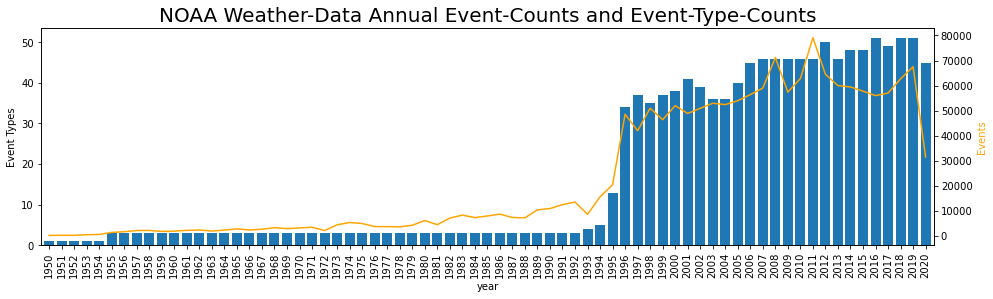

In [50]:
plt.figure()
width = 0.8 # width of a bar
events_by_year_df['event_types'].plot(kind='bar', width = width, figsize = (16,4))
plt.ylabel("Event Types")
# Get axis so can set params on it later
ax = plt.gca()
ax.set_title("NOAA Weather-Data Annual Event-Counts and Event-Type-Counts", size = 20)
events_by_year_df['events'].plot(secondary_y=True, color='orange')
plt.ylabel("Events", color='orange')
# x-axis label settings
ax.tick_params(axis='x',labelrotation=90)

#### Observations ####
It looks like there are effectively two different data-sets to consider:

+ a long term trend of a very small number of event-types since 1955  
+ more detailed collection of events since 1996 to current day.  


# Weather Events causing Injuries and Deaths #
The NOAA weather-data has 4 columns recording weather related death and injuries:
+ 'injuries_direct',
+ 'injuries_indirect'
+ 'deaths_direct'
+ 'deaths_indirect'  
  
We can identify 
1. Which weather events have the biggest combined impact on life and health (injury)
2. Where these events are most prevalent.

In [88]:
# Use Snowflake to perform a bulk-aggregate operation and return results into a Pandas data-frame
cur = conn.cursor()
cur.execute("""SELECT event_type
           , sum(injuries_direct) injuries_direct
           , sum(injuries_indirect) injuries_indirect
           , sum(deaths_direct) deaths_direct
           , sum(deaths_indirect) deaths_indirect
FROM noaa_events
WHERE injuries_direct + injuries_indirect + deaths_direct + deaths_indirect > 0
GROUP BY event_type 
ORDER BY 2,4 DESC""")

event_injury_death = cur.fetchall()

# Copy Snowflake results into a Pandas dataframe
event_injury_death_df = pd.DataFrame(event_injury_death)

cols_list = [c[0].lower() for c in cur.description ]
event_injury_death_df.columns = cols_list
event_injury_death_df.set_index('event_type', inplace=True)

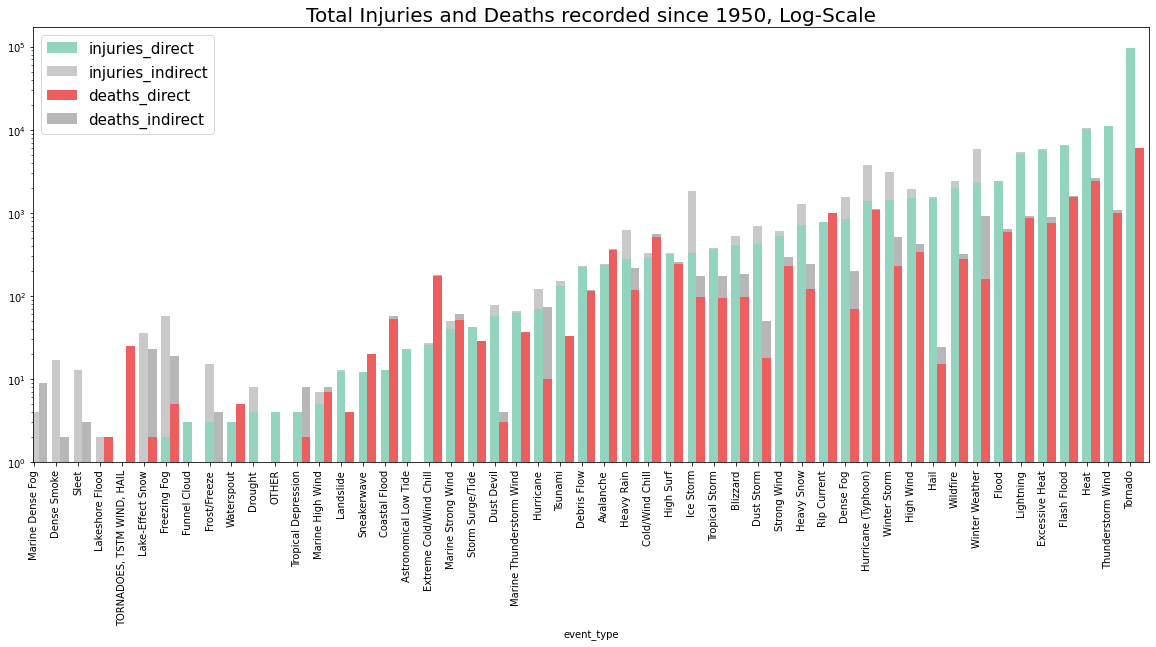

In [104]:
fig, ax = plt.subplots(figsize=(20, 8))
event_injury_death_df[['injuries_direct', 'injuries_indirect']].plot.bar(stacked=True
                                                                     , width=0.4
                                                                     , position=0.5
                                                                     , colormap="Set2"
                                                                     , logy = True
                                                                     , ax=ax, alpha=0.7)
event_injury_death_df[['deaths_direct', 'deaths_indirect']].plot.bar(stacked=True
                                                                     , width=0.4
                                                                     , position=-0.5
                                                                     , colormap="Set1"
                                                                     , logy = True
                                                                     , ax=ax, alpha=0.7)
plt.legend(loc="best", prop={'size': 15})
ax.set_title("Total Injuries and Deaths recorded since 1950, Log-Scale", size =20)
plt.show()

Clearly Tornados are by far the worst events for personal injury and loss of life (as the above chart is plotted on a log-scale).  We can use Plotly and chorpeth map-charts to identify if there are particular regions where there is a higher incidence of deaths caused by tornadoes.

### Using Python Plotly to Plot Geographical Data ###
Follow the approach documented here: https://plotly.com/python/choropleth-maps/

In [127]:
# Get a data-set of deaths_direct summarised by state_fips
cur.execute("""SELECT state_fips, sum(deaths_direct) deaths_direct
FROM noaa_events 
WHERE event_type = 'Tornado'
GROUP BY state_fips""")
tornado_death_states_df = pd.DataFrame(cur.fetchall())
tornado_death_states_df.columns = [c[0].lower() for c in cur.description ]

# Source a table of mappings to map the state_fips code in the Snowflake NOAA dataset to a two letter US state
URL = 'https://raw.githubusercontent.com/edbullen/Snowflake/master/us_state_fips.csv'
states_df = pd.read_csv(URL, header=None, index_col=False)
states_df.columns = ["state", "letter_code", "state_fips", "status"]

# Join state letter_code to data-set
tornado_death_states_df = pd.merge(tornado_death_states_df, states_df[["state_fips","letter_code"]]
                         , left_on='state_fips', right_on='state_fips', how='left')

In [139]:
# Plotly map plot
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(
    locations=tornado_death_states_df['letter_code'], # Spatial coordinates
    z = tornado_death_states_df['deaths_direct'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Deaths",
    )
)

fig.update_layout(
    title_text = 'Total Tornado Deaths since 1950 by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

# Weather Event Trends - 1996 to 2019 #
Due to the apprent change in data gathering volume and detail since 1996, it is probably not valid to look at trends over time before 1996.  At the time of writing, data for 2020 is not complete, so we can assess a 23 year period with a complete data-set of detailed observations.
  
Instead of running the aggregation operations in Snowflake, the data can be filtered from a particular point in time (between 1996 and 2019) and loaded into a Pandas data-frame for further local filter, join and aggregate operations in Python.

In [140]:
# Select event data from 1996 to 2019
cur = conn.cursor()
cur.execute("""select to_char(begin_date_time, 'YYYY') year
   , to_char(begin_date_time, 'YYYYMM') yearmonth
   , state
   , state_fips
   , event_type
   , datediff(hour, begin_date_time, end_date_time) duration
   , damage_property_num * damage_property_units  damage_property_usd
   , damage_crops_num * damage_crops_units  damage_crops_usd
   , deaths_direct
   , deaths_indirect
   , injuries_direct
   , injuries_indirect
FROM noaa_events
WHERE to_char(begin_date_time, 'YYYY') > 1995
AND to_char(begin_date_time, 'YYYY') < 2020
ORDER BY yearmonth""")

events = cur.fetchall()

In [141]:
# Load data into a Pandas data-frame and set the column-names
events_df = pd.DataFrame(events)
cols_list = [c[0].lower() for c in cur.description ]
events_df.columns = cols_list

#### Event-Type Frequencies Post 1995 ####

<AxesSubplot:title={'center':'NOAA Event-Type Frequencies, post 1995'}>

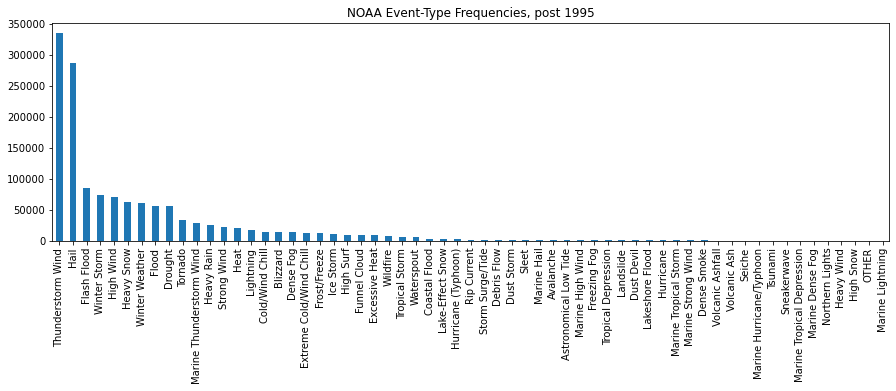

In [142]:
events_df.set_index('year', inplace=True)
events_df['event_type'].value_counts().plot.bar(figsize = (15,4), title="NOAA Event-Type Frequencies, post 1995")

The weather-event "Thunderstorm Wind" is the most frequently occurring event over the period 1996 to 2019 and it is also a major cause of injury and death (second only to Tornados).  It would be interesting to see if there is an increase in the number of these events over this period.

#### Use Statsmodels and OLS to analyze annual Thunderstorm Event trend ####
OLS (Ordinary Least Squares) simple linear regression can be used to try fitting a linear trend to the event occurrences per year.  The Python `statsmodels` package provides some statistics measures to determine whether any apparent trend is significant.

In [195]:
#conda install -c conda-forge statsmodels
import statsmodels.api as sm

# Summarise counts of storm event counts by year
storm_events_year_df = events_df.loc[events_df['event_type'] == 'Thunderstorm Wind'].reset_index()
storm_events_year_df = storm_events_year_df[['year']].groupby(['year']).size().reset_index()
storm_events_year_df.columns = ["year", "occurrences"]

In [196]:
storm_events_year_df.head()

,year,occurrences
0,1996,10084
1,1997,9868
2,1998,13603
3,1999,10347
4,2000,12408


In [197]:
# integer list for x-axis time-series of years 0 -> 23.
years = list(range(0,len(storm_events_year_df)) ) 
# mechanism for allowing statsmodels ols to fit an intercept 
# https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit
x_intercept = sm.add_constant(years) 
# fit an OLS model
ols_model = sm.OLS(storm_events_year_df['occurrences'], x_intercept).fit()
# Print some metrics about the effectivnes of fitting a linear model and the gradient of slope
print("Gradient: {}, F-Statistic: {}, P-Value: {}, R-squared: {}".format(
    ols_model.params[1].round(4), ols_model.fvalue.round(4), ols_model.pvalues[1].round(4), ols_model.rsquared.round(4)) )

Gradient: 280.4183, F-Statistic: 24.5405, P-Value: 0.0001, R-squared: 0.5273


The very low P-Value (less than 0.05) and large gradient suggest a strong likelihood of a postive upward trend in storm events per year.  The R-value suggest a lot of variability in the data.
#### Plot Annual Storm Events and Linear Regression Trend ####

Text(0.5, 1.0, 'USA Increase in Thunderstorm / Wind Events per Year')

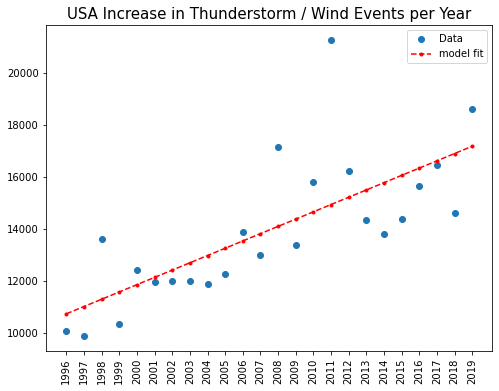

In [202]:
fig, ax = plt.subplots(figsize=(8,6))
year_xticks = list(storm_events_year_df['year'])
ax.plot(years,storm_events_year_df['occurrences'], 'o', label="Data")
ax.plot(years, ols_model.fittedvalues, 'r--.', label="model fit")

ax.set_xticks(years)
ax.set_xticklabels(year_xticks, rotation=90)

ax.legend(loc='best')
ax.set_title("USA Increase in Thunderstorm / Wind Events per Year", size = 15)

By generating a trend per state over the period 1996 to 2019, it is possible to see which states are experiencing the greatest *rate of increase* of storm events.

### NOAA Thunder/Wind Event Occurrence, Counts by State per Year - 1996 to 2019 ###

#### Define a Function to generate a matrix of plots ####

In [200]:
# Print a 12x5 grid of trends for each state.  
# Pass in a df with states in cols, with row-vals to plot as timeseries based on index for dates
def multiplot(df, title=None, color='black'):
    # multiple line plot counter
    n = 0
    xlim = len(df)

    # Set the figure size
    f = plt.figure(figsize=(16,16))

    # Loop through states, plotting figures
    for state in df.columns:
        n += 1
        # Find the right spot on the plot
        ax = f.add_subplot(12,5,n)
        ax.set_xlim([0, xlim])
        #ax.set_ylim([0, 20000])  # Don't set y-lim so trends for different states are clear
        ax.set_xticklabels([])
        f.subplots_adjust(hspace=0.5)

        ax.plot(df.index, df[state], marker='', color=color, linewidth=1.9, alpha=0.9)
        ax.set_title(state)
    if title:
        f.suptitle(title, size=20, y=0.92)

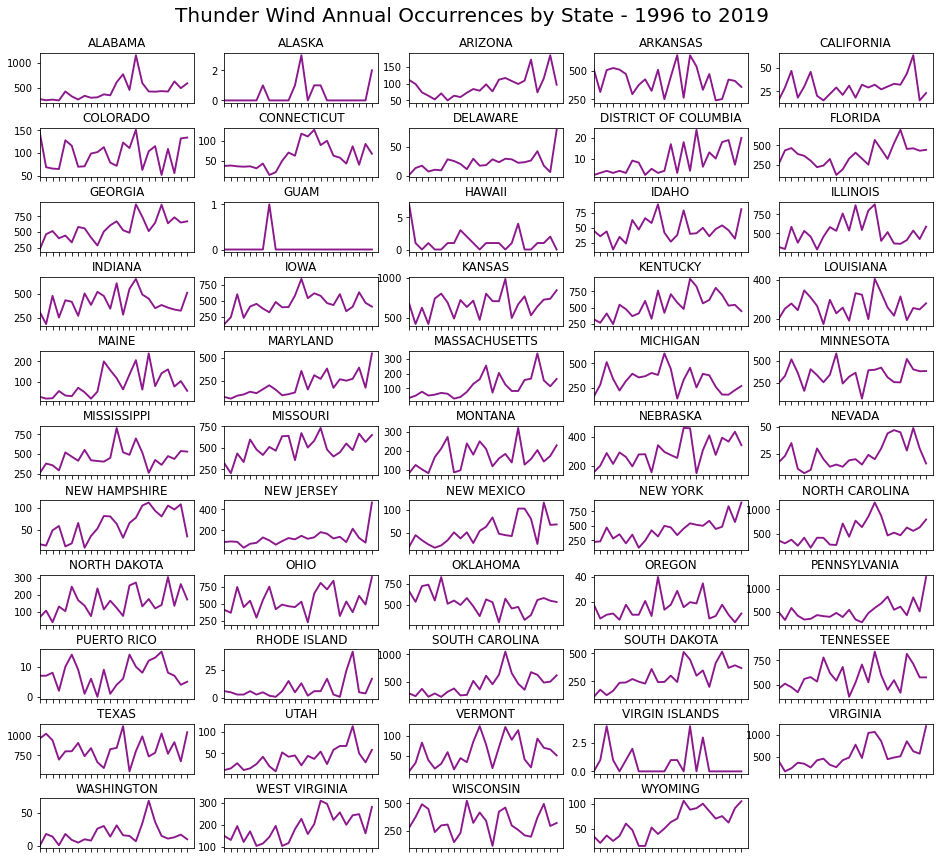

In [203]:
storm_events_df = events_df.loc[events_df['event_type'] == 'Thunderstorm Wind'].reset_index()
storm_events_df = storm_events_df[["year", "state"]].groupby(["year", "state"]).size().reset_index(name='occurrences')
# pivot with Year as index, states as cols in a matrix fmt
storm_events_df = storm_events_df.pivot(index='year', columns='state', values='occurrences').fillna(0)
multiplot(storm_events_df, title = "Thunder Wind Annual Occurrences by State - 1996 to 2019", color = 'purple')

By visual inspection it appears that some states have a greater increase in storm events over time than others.  The overall trend for the USA is probably not relevant to all parts of the US.